<hr style="border:2px solid gray">

##### Author  : SIVA VIKNESH 
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com 
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA 
<hr style="border:2px solid gray">

In [1]:
import os
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]
from scipy.linalg import circulant, toeplitz, inv
import h5py
from itertools import combinations
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True, precision=15)

Asensio & Ferragut: Wildfire combustion model

$$
\begin{align}
\frac{\partial \overline{T}}{\partial \tau} + \overrightarrow{\mathbf{V}} \cdot \nabla \overline{T} &= \overline{\kappa} \nabla^2 \overline{T} + s(\overline{T})^{+} \beta \mathrm{e}^{\overline{T}/(1 + \epsilon \overline{T})} - \alpha \overline{T} \\[6pt]
\frac{\partial \beta}{\partial \tau} &= -s(\overline{T})^{+} \hspace{1mm} \frac{\epsilon}{q} \beta \mathrm{e}^{\overline{T}/(1 + \epsilon \overline{T})}
\end{align}
$$

Considering the steady uniform wind velocity field along North-East direction : $$\begin{align}
u = V_{mag} \sin(\pi/4) , \hspace{0.2cm} v = V_{mag} \cos(\pi/4 ) 
\end{align}
$$

Parameters: \\(\overline{\kappa}\\), \\(\epsilon\\), \\(\overrightarrow{\mathbf{V}}\\), \\(\alpha\\)

In [2]:
xmin =  0.0
xmax =  2.0
Nx   =  256
dx   = (xmax - xmin) / Nx

ymin =  0.0
ymax =  1.0                                          
Ny   =  128
dy   = (ymax - ymin) / Ny

Vmag    = 10.0
t       = 0.0
eps     = 3e-1                                           # INVERSE OF ACTIVATION ENERGY
alpha   = 2e-1                                           # NON-DIMENSIONAL NATURAL CONVECTION COEFFICENT
kap     = 1.10                                           # DIFFUSION PARAMETER

x       = np.linspace(xmin, xmax, num=Nx)
y       = np.linspace(ymin, ymax, num=Ny)
X, Y    = np.meshgrid(x, y)

directory   = os.getcwd()                                # GET THE CURRENT WORKING DIRECTORY  
path        = directory + '/' 
file_name   = path + 'Temperature_data/'
Temp_data   = file_name + 'Data_10000.h5'

with h5py.File(Temp_data, 'r') as hf:
        T = np.array(hf['Temperature'][()])
        B = np.array(hf['Fuel'][()])
        hf.close()

In [3]:
def OUCS2(N, h):
    d = np.zeros(N)
    
    a  = -40.0

    p33 = 36.0
    p32 = p33 / 3.0 - a / 12.0
    p34 = p33 / 3.0 + a / 12.0

    d[1]  = p32
    d[0]  = p33
    d[-1] = p34

    D1 = circulant(d)

    d = np.zeros(N)

    q31 = -p33 / 36.0 + a / 72.0
    q32 = -7.0 * p33 / 9.0 + a / 9.0
    q33 = -a / 4.0
    q34 = 7.0 * p33 / 9.0 + a / 9.0
    q35 = p33 / 36.0 + a / 72.0

    beta1 = 0.020
    beta2 = 0.090 

    d[-2] = q35
    d[-1] = q34
    d[0]  = q33
    d[1]  = q32
    d[2]  = q31

    D2 = circulant(d) / h

    out = inv(D1) @ D2

    out[0:2, :] = 0.0
    out[0, :3] = np.array([-3.0, 4.0, -1.0]) / (2.0 * h)
    out[1, :5] = np.array([2.0 * beta1 / 3.0 - 1.0 / 3.0, -(8.0 * beta1 / 3.0 + 0.50), 4.0 * beta1 + 1.0, -(8.0 * beta1 / 3.0 + 1.0 / 6.0), 2.0 * beta1 / 3.0])

    out[-2:, :] = 0.0
    out[-2, -5:] = np.array([-2.0 * beta2 / 3.0, 8.0 * beta2 / 3.0 + 1.0 / 6.0, -(4.0 * beta2 + 1.0), 8.0 * beta2 / 3.0 + 0.50, -(2.0 * beta2 / 3.0 - 1.0 / 3.0)])
    out[-1, -3:] = np.array([1.0, -4.0, 3.0]) / (2.0 * h)

    return out

def CD2(N, h):
    a11, a12, a13 =  1.0, 0.0, -1.0 
    d = np.zeros(N)
    d[-1], d[0], d[1] = a11, a12, a13
    D = circulant(d) / (2.0 * h)

    D[0, :] = 0.0
    D[0, :3] = np.array([-3.0, 4.0, -1.0]) / (2.0 * h)

    D[-1, :] = 0.0
    D[-1, -3:] = np.array([1.0, -4.0, 3.0]) / (2.0 * h)
    
    return D


def FUEL_SOURCE (u, beta, eps, alpha):                    # F : TEMPERATURE FUEL-REACTION FUNCTION
    return  beta * np.exp(u / (1.0 + eps * u)) - alpha * u

In [4]:
Vx, Vy    = Vmag*np.sin(np.pi/4), Vmag*np.cos(np.pi/4)

Dx        = OUCS2 (Nx, dx)
Dy        = OUCS2 (Ny, dy)
Dxx       = CD2   (Nx, dx) 
Dyy       = CD2   (Ny, dy)

Tx,  Ty   = np.einsum('ij, kj -> ki', Dx,  T),  np.einsum('ij, jk -> ik', Dy,   T)
T1x, T1y  = np.einsum('ij, kj -> ki', Dxx, T),  np.einsum('ij, jk -> ik', Dyy,  T)
T2x, T2y  = np.einsum('ij, kj -> ki', Dxx, T1x), np.einsum('ij, jk -> ik', Dyy, T1y)
T3x, T3y  = np.einsum('ij, kj -> ki', Dxx, T2x), np.einsum('ij, jk -> ik', Dyy, T2y)
T4x, T4y  = np.einsum('ij, kj -> ki', Dxx, T3x), np.einsum('ij, jk -> ik', Dyy, T3y)

T, B     = T.reshape  (-1, 1), B.reshape  (-1, 1)
Tx, Ty   = Tx.reshape (-1, 1), Ty.reshape (-1, 1)
T1x, T1y = T1x.reshape(-1, 1), T1y.reshape(-1, 1)
T2x, T2y = T2x.reshape(-1, 1), T2y.reshape(-1, 1)
T3x, T3y = T3x.reshape(-1, 1), T3y.reshape(-1, 1)
T4x, T4y = T4x.reshape(-1, 1), T4y.reshape(-1, 1)

Advection    = Vx*Tx + Vy*Ty
Diffusion    = kap*(T2x + T2y)
Reaction     = FUEL_SOURCE (T, B, eps, alpha)
dT_dt        = Diffusion + Reaction - Advection

In [5]:
## SINDy Function Definitions
def sparsifyDynamics(Theta,dXdt,lamb,n): #Solves SINDy's L1 regularized convex optimization problem
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

In [6]:
eps = [0.2, 0.4]

Reaction_term        = FUEL_SOURCE (T, B, eps, 0.0)
All_candidates       = np.hstack((T, Tx, Ty, T2x, T2y, T3x, T3y, T4x, T4y, Reaction_term))


**Considering all the candidates in the optimization**

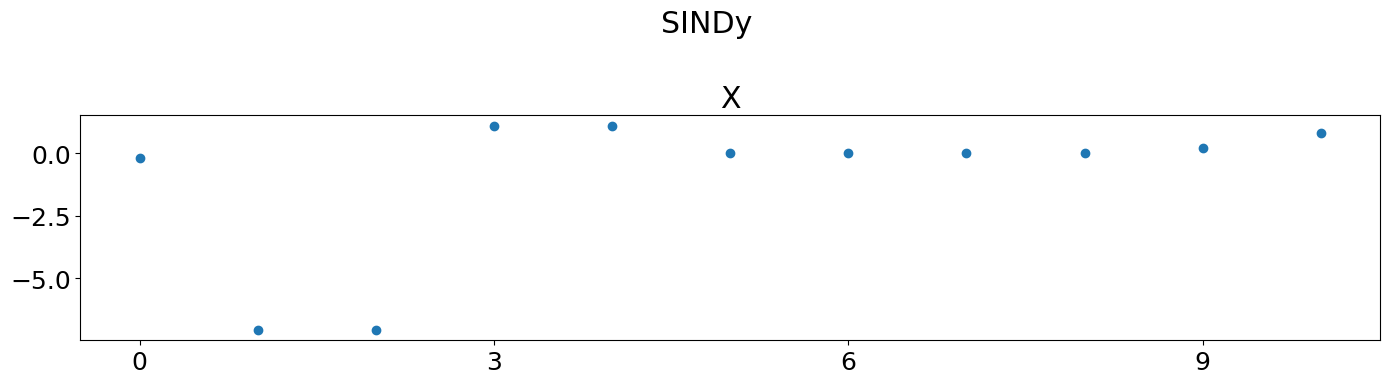

[[-0.193242008508018]
 [-7.071070012558542]
 [-7.071078400203441]
 [ 1.100004916337128]
 [ 1.100004908911591]
 [ 0.               ]
 [ 0.               ]
 [ 0.               ]
 [ 0.               ]
 [ 0.186668123435053]
 [ 0.817144833992933]]


In [7]:
lamb = 0.01 # sparsification knob lambda
coeff_matrix = sparsifyDynamics(All_candidates, dT_dt, lamb, 1)

#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize =(14, 4))
fig.suptitle('SINDy')

ax.plot(coeff_matrix, 'o') 
ax.set_title('X')
ax.xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

print(coeff_matrix)
